### Loading and prerequesites

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
VARIANT = "FULL" # "SMALL", "MEDIUM" , "FULL"

if VARIANT == "SMALL":
    df = pd.read_pickle("../Data/df.pkl")
    df = df.head(30)
elif VARIANT == "MEDIUM":
    df = pd.read_pickle("../Data/df.pkl")
    df = df.head(500)
else:
    df = pd.read_pickle("../Data/df.pkl")

### General overview over the dataset

In [3]:
df

,nexis_id,title,publication_date,publication_year,publisher,text,language
0,5MNMH621JB0GF09H0000000,Angst vor dem «harten Brexit» auf der Insel - ...,2017-01-15,2017,AP Deutsch,Wenn Großbritannien Ende März den Ausstieg aus...,DE
1,5SM3THB1DXFJ50MP0000000,Fleischindustrie wehrt sich gegen Marketing fü...,2018-06-21,2018,AP Deutsch,Fleisch aus dem Labor ist noch eine Zukunftsvi...,DE
2,5SM3THB1DXFJ50MY0000000,Der AP-Überblick am Nachmittag,2018-06-21,2018,AP Deutsch,Die AP Weltnachrichten haben heute unter ander...,DE
3,5STNVWH1DXFJ53VM0000000,Laborfleisch soll in drei Jahren auf die Telle...,2018-07-17,2018,AP Deutsch,Maastricht (AP) - Das niederländische Unterneh...,DE
4,5VHK2XG1JB0GF4Y50000000,Israelische Forscher wollen künstliche Steaks ...,2019-02-26,2019,AP Deutsch,"Die Weltbevölkerung wächst, die Nachfrage nach...",DE
...,...,...,...,...,...,...,...
5301,67KW1VK1F15WB4660000000,Kein Titel,2023-02-21,2023,ZEIT Wissen,6 Am anfang drei Fragen 1. Können wir andere m...,DE
5302,67KW1VK1F15WB46B0000000,Leben und schmecken lassen,2023-02-21,2023,ZEIT Wissen,"Ein saftiges Filet, für das kein Huhn sterben ...",DE
5303,7W29GN20YC2460S30000000,ABSCHIED VOM ALTEN ITALIEN,2009-05-13,2009,ZEIT Wissen,John Dickie: »Delizia! Die Italiener und ihre...,DE
5304,7X8DW4712SK2G0H10000000,Essen aus dem Labor,2009-12-08,2009,ZEIT Wissen,Es ist der letzte Tag auf der Lebensmittelmess...,DE


In [4]:
print("First Textual Overview of the Dataset:")
print("------------------------")
print("First Publication Year:", df['publication_date'].min().year)
print("Last Publication Year:", df['publication_date'].max().year)
print("Total Number of Publications:", len(df))
print("\nNumber of Publications per Year:")
print(df['publication_year'].value_counts().sort_index())
print("\nNumber of Publications per Publisher:")
print(df['publisher'].value_counts())

First Textual Overview of the Dataset:
------------------------
First Publication Year: 1992
Last Publication Year: 2023
Total Number of Publications: 5306

Number of Publications per Year:
publication_year
1992      3
1993      6
1994     18
1995     20
1996     29
1997     49
1998     61
1999     97
2000    100
2001     64
2002     69
2003    151
2004    322
2005    191
2006    147
2007    127
2008    159
2009    137
2010     96
2011    105
2012    127
2013    155
2014    239
2015    201
2016    225
2017    136
2018    282
2019    256
2020    210
2021    348
2022    353
2023    823
Name: count, dtype: int64

Number of Publications per Publisher:
publisher
taz, die tageszeitung        428
Lebensmittel Zeitung         371
Frankfurter Rundschau        180
Stuttgarter Zeitung          179
dpa-AFX ProFeed              164
                            ... 
Blick am Abend                 1
BILD Sachsen-Anhalt            1
Mlr Baden Wuerttemberg.de      1
BILD Frankfurt                 1
Logi

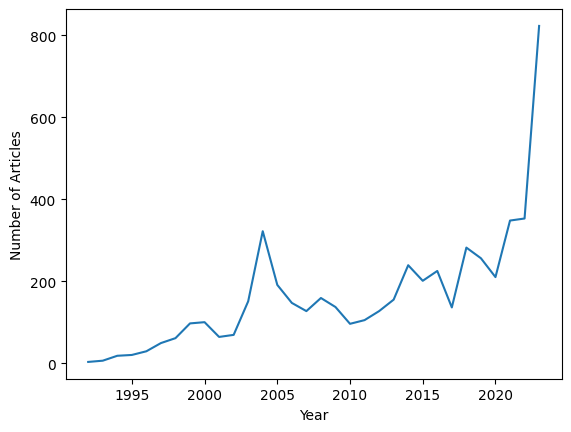

In [5]:
# Overview over yearly publications
df['publication_year'].value_counts().sort_index().plot(legend = None)
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.savefig('../Visuals/articles_per_year.png')
plt.show()

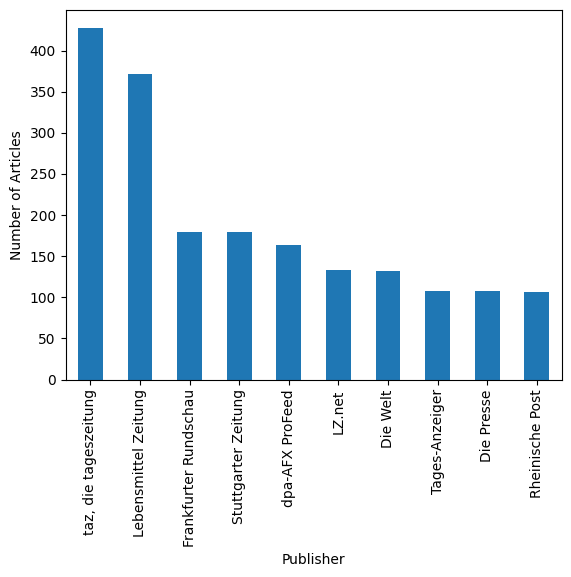

In [6]:
# Overview over publishers with most publications
df['publisher'].value_counts().nlargest(10).plot(legend = None, kind='bar',)
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.savefig('../Visuals/top_10_publishers.png')
plt.show()

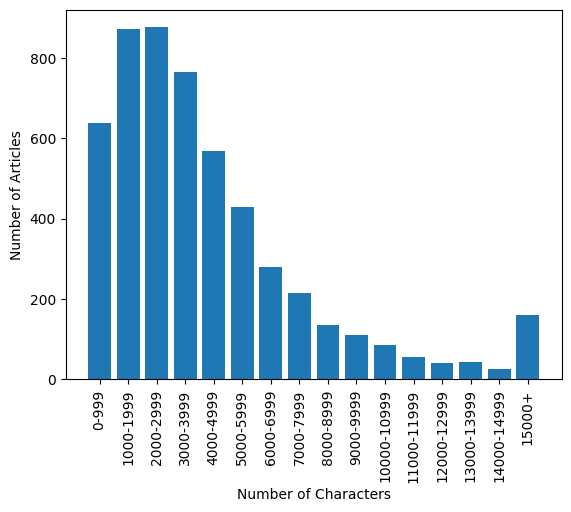

In [7]:
# Overview over articles length
# Define the intervals
intervals = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, float('inf')]

# Group the articles based on length intervals
grouped_articles = df.groupby(pd.cut(df['text'].str.len(), intervals)).size()

# Plot the bar plot
plt.bar(range(len(grouped_articles)), grouped_articles)

# Set the x-axis labels
plt.xticks(range(len(grouped_articles)), [f'{int(x.left)}-{int(x.right-1)}' if x.right != float('inf') else f'{int(x.left)}+' for x in grouped_articles.index], rotation=90)

# Set the x-axis label
plt.xlabel('Number of Characters')

# Set the y-axis label
plt.ylabel('Number of Articles')

# Save the plot
plt.savefig('../Visuals/articles_grouped_by_length.png')

# Show the plot
plt.show()

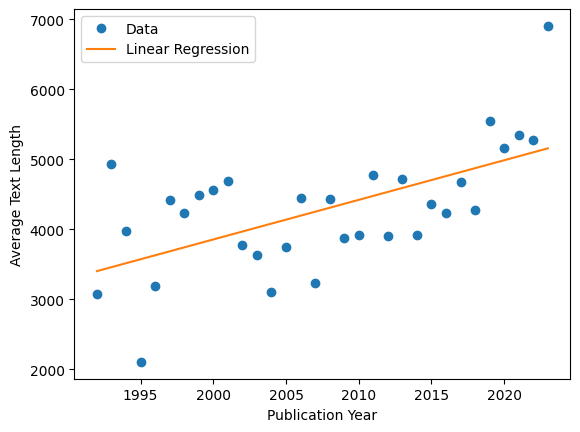

In [8]:
# Calculate the average length of text for each publication year
df_grouped = df.groupby('publication_year')['text'].apply(lambda x: x.str.len().mean()).reset_index()

# Fit a linear regression curve to the data
coefficients = np.polyfit(df_grouped['publication_year'], df_grouped['text'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_grouped['publication_year'].min(), df_grouped['publication_year'].max(), 100)

# Plot the data points and the polynomial curve
plt.plot(df_grouped['publication_year'], df_grouped['text'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Publication Year')

# Set the y-axis label
plt.ylabel('Average Text Length')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/yearly_text_length.png')

# Show the plot
plt.show()

### Frequent words

In [9]:
# Use small spacy model
df_spacy_sm = pd.read_pickle("../Data/df_spacy_sm.pkl")
df = df_spacy_sm.copy()

spacy_sm
Prozent         11286
Lebensmittel     7470
Fleisch          7075
Produkt          6268
Unternehmen      5737
gentechnisch     5381
Mensch           5042
Deutschland      4407
USA              4286
deutsch          4162
stehen           4018
verändert        4001
Gentechnik       3863
sehen            3775
Pflanze          3577
Tier             3397
Verbraucher      3316
Markt            3173
Euro             3004
EU               2895
Name: count, dtype: int64


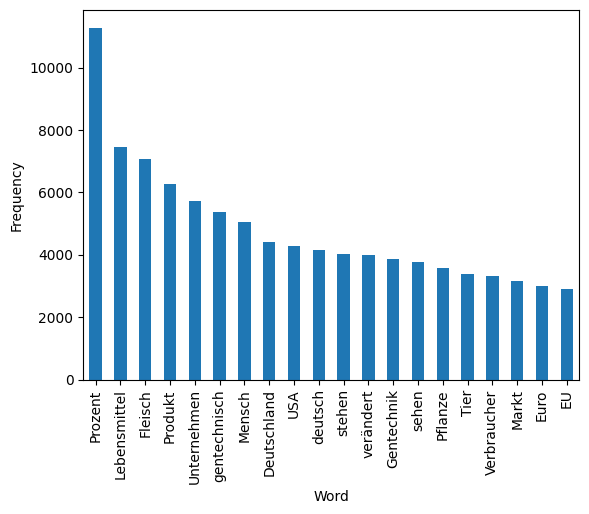

In [13]:
# Find the most frequent words in df and their frequencies
word_freq = df['spacy_sm'].apply(lambda x: [token.lemma_ for token in x if not token.is_stop and not token.is_punct and not token.is_digit]).explode().value_counts()
#word_freq = df['spacy_sm'].apply(lambda x: [token.lemma_ for token in x]).explode().value_counts()

# Remove whitespace-only strings
word_freq = word_freq[word_freq.index.str.strip() != '']

# Remove double lines
word_freq = word_freq[word_freq.index.str.strip() != '--']

# Workaround: Remove all texts where the words "and", "the", "to" and "of" appear more than twice.
# No longer needed since all non-german articles have been removed
#word_freq = word_freq[(word_freq.index != 'and') & (word_freq.index != 'the') & (word_freq.index != 'The') & (word_freq.index != 'to') & (word_freq.index != 'of')]
#word_freq = word_freq[word_freq > 2]

# Print the most frequent words as text
print(word_freq.nlargest(20))

# Plot the 20 most frequent words
word_freq.nlargest(20).plot(kind='bar')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.savefig('../Visuals/top_20_words.png')
plt.show()

In [24]:
# Find the texts with the most occurences of "Prozent"
df['prozent_count'] = df['spacy_sm'].apply(lambda x: sum([1 for token in x if token.lemma_ == 'Prozent']))
df['prozent_count'].nlargest(10)

# Print the texts with the most occurences of "Prozent", the frequency of the word "Prozent" and the publisher of the article
for i in df['prozent_count'].nlargest(10).index:
    print(df.loc[i]['publisher'])
    print(df.loc[i]['text'])
    print(df.loc[i]['prozent_count'])
    print('------------------------')

print()

print(str(sum(df['prozent_count'] > 5)) + ' Artikel mit mehr als 5 Vorkommen von Prozent')
print(str(sum(df['prozent_count'] > 50)) + ' Artikel mit mehr als 50 Vorkommen von Prozent')


Bayerischer Rundfunk
22.00 Uhr - Wall Street schließt mit kräftigen Gewinnen Die US-Börsen können nach einer eher zähen Woche zum Ende kräftige Gewinne verbuchen: Der Dow Jones ist fast ein Prozent fester aus dem Handel gegangen, der Nasdaq konnte um anderthalb Prozent zulegen... 22.00 Uhr - Wall Street schließt mit kräftigen Gewinnen  Die US-Börsen können nach einer eher zähen Woche zum Ende kräftige Gewinne verbuchen: Der Dow Jones ist fast ein Prozent fester aus dem Handel gegangen, der Nasdaq konnte um anderthalb Prozent zulegen. Positiv kamen bei Anlegern unter anderem die stagnierenden US-Konsumausgaben im Mai an. Gefragt waren außerdem Tech-Werte und Banken-Titel. Apple hat erstmals in der Geschichte zu Börsenschluss einen Wert von mehr als drei Billionen Dollar.  21.09 Uhr - US-Banken an der Wall Street gefragt  In den USA greifen Anlegerinnen und Anleger bei den Aktien von Banken zu: JP Morgan, Bank of America, Wells Fargo und Morgan Stanley gewinnen bis zu 1,7 Prozent. Dies s

### Questions

In [24]:
# Use small spacy model
df_spacy_sm = pd.read_pickle("../Data/df_spacy_sm.pkl")
df = df_spacy_sm.copy()

In [25]:
def count_questions(text):
    return sum(1 for sent in text.sents if sent.text.strip().endswith('?'))

In [26]:
df['questions_count'] = df["spacy_sm"].apply(count_questions)

In [27]:
# Add a column with the number of characters in the text
df['characters_count'] = df['text'].str.len()

# Add a column with the ratio of questions to characters
df['questions_ratio'] = df['questions_count'] / df['characters_count']

In [28]:
df
df_sorted = df.sort_values(by='questions_ratio', ascending=False)
df_sorted

,nexis_id,title,publication_date,publication_year,publisher,text,spacy_sm,questions_count,characters_count,questions_ratio
4338,67DH39P1JC8114CH0000000,"Vegan, aber ?Fleischerei??",2023-01-27,2023,Sächsische Zeitung Regionalausgaben,Schnitzel- und Fleischkäsebrötchen auf die Han...,"(Schnitzel-, und, Fleischkäsebrötchen, auf, di...",41,4195,0.009774
805,5S2T9DY1JCTWB3T40000000,1 Essen nach maß 30 31 38 41,2018-04-11,2018,Der Standard,19 24 Mythen im Faktencheck Was bringen Detox-...,"(19, 24, Mythen, im, Faktencheck, Was, bringen...",1,108,0.009259
521,5WWBF9D1F07YK01F0000000,FOOD-NEWS,2019-08-22,2019,Bunte,Wurst- und Fleisch-alternativen EVENTLOCATION ...,"(Wurst-, und, Fleisch-alternativen, EVENTLOCAT...",1,108,0.009259
939,7XMCMWY12RKCK2JP0000000,Der Mai ist nicht gekommen Von Harald Martenstein,2010-01-24,2010,Der Tagesspiegel,Im Mai wird die Sonne scheinen - ganz bestimmt...,"(Im, Mai, wird, die, Sonne, scheinen, -, ganz,...",20,2371,0.008435
5417,5NV18G31F15WB0890000000,FORSCHUNG & TECHNIK,2017-06-20,2017,ZEIT Wissen,"Tanker, Frachter, Piraten: Auf dem Meer ist wa...","(Tanker, ,, Frachter, ,, Piraten, :, Auf, dem,...",14,1918,0.007299
...,...,...,...,...,...,...,...,...,...,...
1280,4CD8D5X0TWCNH2120000000,Reklame für die Werber,2004-05-16,2004,Welt am Sonntag,"Dieser Tage wird wieder gekleistert, was das Z...","(Dieser, Tage, wird, wieder, gekleistert, ,, w...",0,5977,0.000000
3033,627SNY51JBR842K00000000,HUNGER-GAMES,2021-03-19,2021,manager magazin,"Erbsenmasse, vermatscht mit Rapsöl und allerle...","(Erbsenmasse, ,, vermatscht, mit, Rapsöl, und,...",0,14569,0.000000
3034,65S924K1JBR841DW0000000,Register,2022-06-24,2022,manager magazin,A AAK 104 Adidas 58 Adler Group 22 Advent 12 A...,"(A, AAK, 104, Adidas, 58, Adler, Group, 22, Ad...",0,6619,0.000000
3035,65S924K1JBR841FY0000000,"Timo Recker, Vegginator",2022-06-24,2022,manager magazin,Wenn Der Spross einer Partyservicedynastie ist...,"(Wenn, Der, Spross, einer, Partyservicedynasti...",0,2268,0.000000


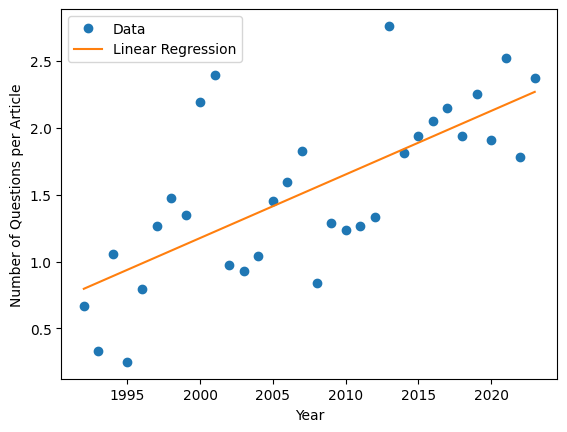

In [18]:
# Visualize the number of questions per article per year and fit a linear regression curve to the data
# Group by year and calculate the total number of questions and total number of articles for each year
df_grouped = df.groupby('publication_year').agg({'questions_count': 'sum', 'text': 'count'})

# Calculate the ratio of questions to total articles for each year
df_grouped['questions_ratio'] = df_grouped['questions_count'] / df_grouped['text']

# Fit a linear regression curve to the data
polynomial = np.poly1d(np.polyfit(df_grouped.index, df_grouped['questions_ratio'], 1))

# Generate x values for the curve
x = np.linspace(df_grouped.index.min(), df_grouped.index.max(), 100)

# Plot the data points and the polynomial curve
plt.plot(df_grouped.index, df_grouped['questions_ratio'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the labels
plt.xlabel('Year')
plt.ylabel('Number of Questions per Article')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/questions_ratio_per_text.png')

# Show the plot
plt.show()

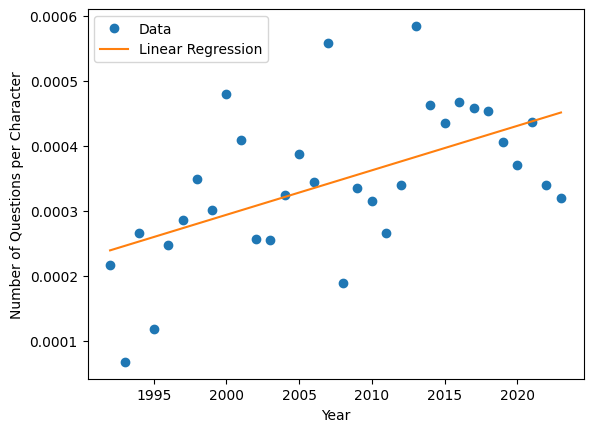

In [16]:
# Visualize the ratio of questions to characters per year and fit a linear regression curve to the data
# Group by year and calculate the total number of questions and total number of characters for each year
df_grouped = df.groupby('publication_year').agg({'questions_count': 'sum', 'characters_count': 'sum'})

# Calculate the ratio of questions to total characters for each year
df_grouped['questions_ratio'] = df_grouped['questions_count'] / df_grouped['characters_count']

# Fit a linear regression curve to the data
polynomial = np.poly1d(np.polyfit(df_grouped.index, df_grouped['questions_ratio'], 1))

# Generate x values for the curve
x = np.linspace(df_grouped.index.min(), df_grouped.index.max(), 100)

# Plot the data points and the polynomial curve
plt.plot(df_grouped.index, df_grouped['questions_ratio'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the labels
plt.xlabel('Year')
plt.ylabel('Number of Questions per Character')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/questions_ratio_per_character.png')

# Show the plot
plt.show()

### Pronouns

In [17]:
# Use small spacy model
df_spacy_sm = pd.read_pickle("../Data/df_spacy_sm.pkl")
df = df_spacy_sm.copy()

In [18]:
du_variants = ["Du", "du", "Dich", "dich," "Dein", "dein", "Deine", "deine", "Deines" , "deines", "Deiner", "deiner", "Dir", "dir"]
ihr_variants = ["Ihr", "ihr", "Euch", "euch", "Euer", "euer", "Ihre", "ihre"]

In [19]:
df["count_du"] = 0
df["count_ihr"] = 0
df["count_du_ihr"] = 0

for index in df.index:
    du = 0
    ihr = 0
    for token in df["spacy_sm"][index]:
        if token.text in du_variants:
            du += 1
        if token.text in ihr_variants:
            ihr += 1
    df.loc[index, "count_du"] = du
    df.loc[index, "count_ihr"] = ihr
    du_ihr = du + ihr
    df.loc[index, "count_du_ihr"] = du_ihr

In [20]:
df

,nexis_id,title,publication_date,publication_year,publisher,text,questions_count,characters_count,questions_ratio,spacy_sm,count_du,count_ihr,count_du_ihr
0,5MNMH621JB0GF09H0000000,Angst vor dem «harten Brexit» auf der Insel - ...,2017-01-15,2017,AP Deutsch,Wenn Großbritannien Ende März den Ausstieg aus...,1,5529,0.000181,"(Wenn, Großbritannien, Ende, März, den, Aussti...",0,2,2
1,5SM3THB1DXFJ50MP0000000,Fleischindustrie wehrt sich gegen Marketing fü...,2018-06-21,2018,AP Deutsch,Fleisch aus dem Labor ist noch eine Zukunftsvi...,0,5177,0.000000,"(Fleisch, aus, dem, Labor, ist, noch, eine, Zu...",0,1,1
2,5SM3THB1DXFJ50MY0000000,Der AP-Überblick am Nachmittag,2018-06-21,2018,AP Deutsch,Die AP Weltnachrichten haben heute unter ander...,0,4622,0.000000,"(Die, AP, Weltnachrichten, haben, heute, unter...",0,2,2
3,5STNVWH1DXFJ53VM0000000,Laborfleisch soll in drei Jahren auf die Telle...,2018-07-17,2018,AP Deutsch,Maastricht (AP) - Das niederländische Unterneh...,0,1575,0.000000,"(Maastricht, (, AP, ), -, Das, niederländische...",0,0,0
4,5VHK2XG1JB0GF4Y50000000,Israelische Forscher wollen künstliche Steaks ...,2019-02-26,2019,AP Deutsch,"Die Weltbevölkerung wächst, die Nachfrage nach...",0,4588,0.000000,"(Die, Weltbevölkerung, wächst, ,, die, Nachfra...",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5420,67KW1VK1F15WB4660000000,Kein Titel,2023-02-21,2023,ZEIT Wissen,6 Am anfang drei Fragen 1. Können wir andere m...,12,1866,0.006431,"(6, Am, anfang, drei, Fragen, 1., Können, wir,...",1,0,1
5421,67KW1VK1F15WB46B0000000,Leben und schmecken lassen,2023-02-21,2023,ZEIT Wissen,"Ein saftiges Filet, für das kein Huhn sterben ...",0,1849,0.000000,"(Ein, saftiges, Filet, ,, für, das, kein, Huhn...",0,0,0
5422,7W29GN20YC2460S30000000,ABSCHIED VOM ALTEN ITALIEN,2009-05-13,2009,ZEIT Wissen,John Dickie: »Delizia! Die Italiener und ihre...,2,6061,0.000330,"(John, Dickie, :, », Delizia, !, Die, Italiene...",0,3,3
5423,7X8DW4712SK2G0H10000000,Essen aus dem Labor,2009-12-08,2009,ZEIT Wissen,Es ist der letzte Tag auf der Lebensmittelmess...,8,18345,0.000436,"(Es, ist, der, letzte, Tag, auf, der, Lebensmi...",0,6,6


In [21]:
years = []
for i in range(1992, 2024):
    years.append(i)

In [22]:
df_yearly_overview = pd.DataFrame(years, columns=["year"])
df_yearly_overview["publication_count"] = 0
df_yearly_overview["count_characters"] = 0
df_yearly_overview["count_du"] = 0
df_yearly_overview["count_ihr"] = 0
df_yearly_overview["count_du_ihr"] = 0
df_yearly_overview.set_index("year", inplace=True)

# Fill the dataframe with the data
for index in df.index:
    year = df["publication_year"][index]
    df_yearly_overview.loc[year, "publication_count"] += 1
    df_yearly_overview.loc[year, "count_characters"] += df["characters_count"][index]
    df_yearly_overview.loc[year, "count_du"] += df["count_du"][index]
    df_yearly_overview.loc[year, "count_ihr"] += df["count_ihr"][index]
    df_yearly_overview.loc[year, "count_du_ihr"] += df["count_du_ihr"][index]

In [23]:
df_yearly_overview

,publication_count,count_characters,count_du,count_ihr,count_du_ihr
year,,,,,
1992,3,9228,0,2,2
1993,6,29614,0,8,8
1994,18,71602,0,33,33
1995,20,42127,2,12,14
1996,29,92729,0,14,14
1997,49,216767,0,50,50
1998,61,258102,16,61,77
1999,98,438041,4,129,133
2000,100,456613,5,146,151


In [24]:
df_yearly_overview["count_du_per_publication"] = 0.0
df_yearly_overview["count_ihr_per_publication"] = 0.0
df_yearly_overview["count_du_ihr_per_publication"] = 0.0

index_list = df_yearly_overview.index.to_list()
for i in index_list:
    df_yearly_overview.loc[i, "count_du_per_publication"] = df_yearly_overview.loc[i, "count_du"] / df_yearly_overview.loc[i, "publication_count"]
    df_yearly_overview.loc[i, "count_ihr_per_publication"] = df_yearly_overview.loc[i, "count_ihr"] / df_yearly_overview.loc[i, "publication_count"]
    df_yearly_overview.loc[i, "count_du_ihr_per_publication"] = df_yearly_overview.loc[i, "count_du_ihr"] / df_yearly_overview.loc[i, "publication_count"]

In [25]:
df_yearly_overview["count_du_per_year"] = 0.0
df_yearly_overview["count_ihr_per_year"] = 0.0
df_yearly_overview["count_du_ihr_per_year"] = 0.0

index_list = df_yearly_overview.index.to_list()
for i in index_list:
    df_yearly_overview.loc[i, "count_du_per_year"] = df_yearly_overview.loc[i, "count_du"] / df_yearly_overview.loc[i, "count_characters"]
    df_yearly_overview.loc[i, "count_ihr_per_year"] = df_yearly_overview.loc[i, "count_ihr"] / df_yearly_overview.loc[i, "count_characters"]
    df_yearly_overview.loc[i, "count_du_ihr_per_year"] = df_yearly_overview.loc[i, "count_du_ihr"] / df_yearly_overview.loc[i, "count_characters"]

In [26]:
df_yearly_overview

,publication_count,count_characters,count_du,count_ihr,count_du_ihr,count_du_per_publication,count_ihr_per_publication,count_du_ihr_per_publication,count_du_per_year,count_ihr_per_year,count_du_ihr_per_year
year,,,,,,,,,,,
1992,3,9228,0,2,2,0.000000,0.666667,0.666667,0.000000,0.000217,0.000217
1993,6,29614,0,8,8,0.000000,1.333333,1.333333,0.000000,0.000270,0.000270
1994,18,71602,0,33,33,0.000000,1.833333,1.833333,0.000000,0.000461,0.000461
1995,20,42127,2,12,14,0.100000,0.600000,0.700000,0.000047,0.000285,0.000332
1996,29,92729,0,14,14,0.000000,0.482759,0.482759,0.000000,0.000151,0.000151
1997,49,216767,0,50,50,0.000000,1.020408,1.020408,0.000000,0.000231,0.000231
1998,61,258102,16,61,77,0.262295,1.000000,1.262295,0.000062,0.000236,0.000298
1999,98,438041,4,129,133,0.040816,1.316327,1.357143,0.000009,0.000294,0.000304
2000,100,456613,5,146,151,0.050000,1.460000,1.510000,0.000011,0.000320,0.000331


### Overview of the usage of 'Du'

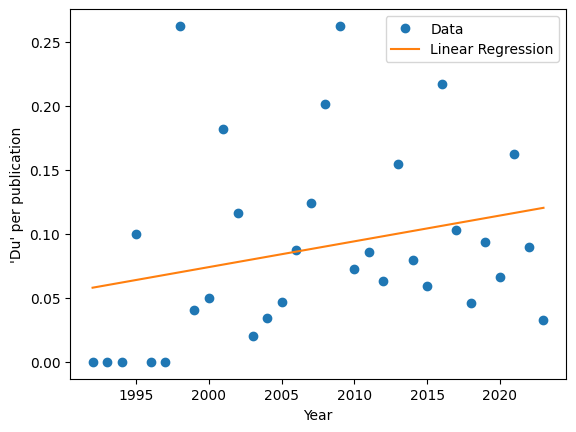

In [27]:
# Visualize the data of 'Du' per publication
# Fit a linear regression curve to the data
coefficients = np.polyfit(df_yearly_overview.index, df_yearly_overview['count_du_per_publication'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_yearly_overview.index.min(), df_yearly_overview.index.max(), 100)

# Plot the data points and the polynomial curve 
plt.plot(df_yearly_overview.index, df_yearly_overview['count_du_per_publication'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('\'Du\' per publication')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/count_du_per_publication.png')

# Show the plot
plt.show()

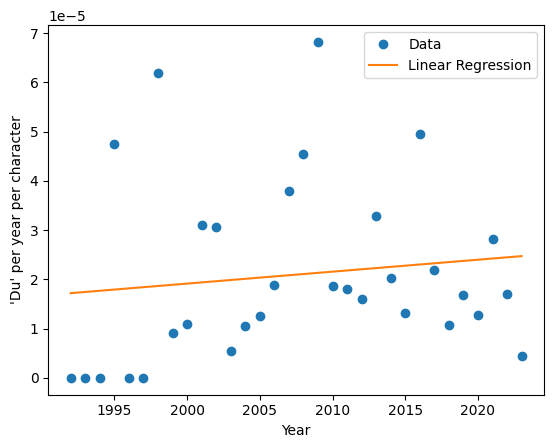

In [28]:
# Visualize the data of 'Du' per year
# Fit a linear regression curve to the data
coefficients = np.polyfit(df_yearly_overview.index, df_yearly_overview['count_du_per_year'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_yearly_overview.index.min(), df_yearly_overview.index.max(), 100)

# Plot the data points and the polynomial curve 
plt.plot(df_yearly_overview.index, df_yearly_overview['count_du_per_year'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('\'Du\' per year per character')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/count_du_per_year_per_character.png')

# Show the plot
plt.show()

### Overview over the usage of 'Ihr'

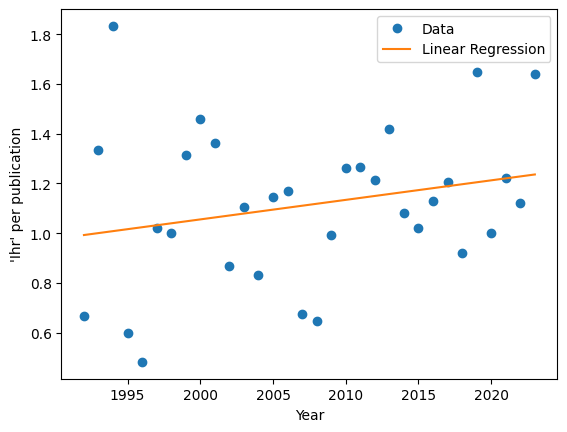

In [29]:
# Visualize the data of 'Ihr' per publication
# Fit a linear regression curve to the data
coefficients = np.polyfit(df_yearly_overview.index, df_yearly_overview['count_ihr_per_publication'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_yearly_overview.index.min(), df_yearly_overview.index.max(), 100)

# Plot the data points and the polynomial curve 
plt.plot(df_yearly_overview.index, df_yearly_overview['count_ihr_per_publication'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('\'Ihr\' per publication')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/count_ihr_per_publication.png')

# Show the plot
plt.show()

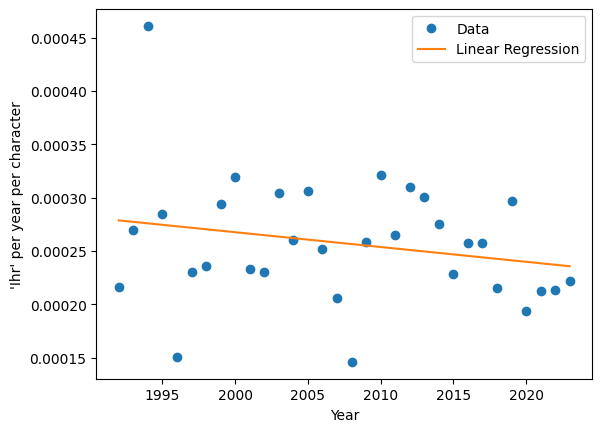

In [30]:
# Visualize the data of 'Ihr' per year
# Fit a linear regression curve to the data
coefficients = np.polyfit(df_yearly_overview.index, df_yearly_overview['count_ihr_per_year'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_yearly_overview.index.min(), df_yearly_overview.index.max(), 100)

# Plot the data points and the polynomial curve 
plt.plot(df_yearly_overview.index, df_yearly_overview['count_ihr_per_year'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('\'Ihr\' per year per character')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/count_ihr_per_year_per_character.png')

# Show the plot
plt.show()

### Overview over the usage of 'Du' / 'Ihr'

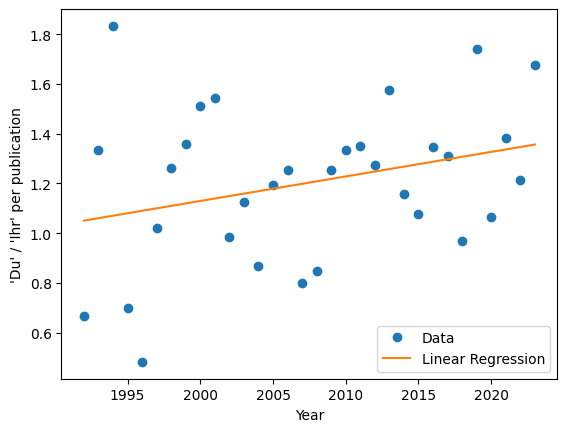

In [31]:
# Visualize the combined data of 'Du' and 'Ihr' per publication
# Fit a 1st-degree polynomial curve to the data
coefficients = np.polyfit(df_yearly_overview.index, df_yearly_overview['count_du_ihr_per_publication'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_yearly_overview.index.min(), df_yearly_overview.index.max(), 100)

# Plot the data points and the polynomial curve
plt.plot(df_yearly_overview.index, df_yearly_overview['count_du_ihr_per_publication'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('\'Du\' / \'Ihr\' per publication')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/count_du_ihr_per_publication.png')

# Show the plot
plt.show()

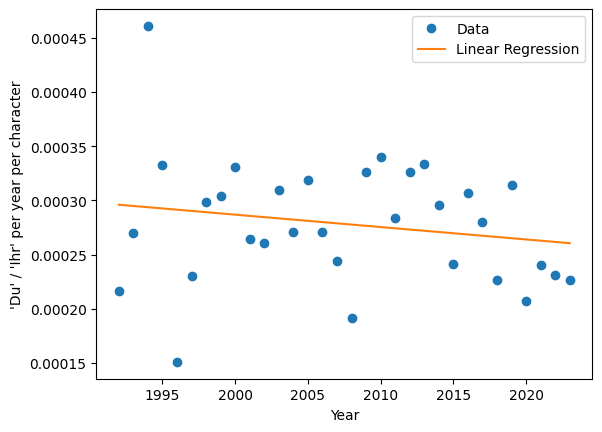

In [32]:
# Visualize the combined data of 'Du' and 'Ihr' per publication
# Fit a 1st-degree polynomial curve to the data
coefficients = np.polyfit(df_yearly_overview.index, df_yearly_overview['count_du_ihr_per_year'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_yearly_overview.index.min(), df_yearly_overview.index.max(), 100)

# Plot the data points and the polynomial curve
plt.plot(df_yearly_overview.index, df_yearly_overview['count_du_ihr_per_year'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('\'Du\' / \'Ihr\' per year per character')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/count_du_ihr_per_year_per_character.png')

# Show the plot
plt.show()